In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
from NN_utils.Layers.Linear import Linear
from NN_utils.Activations.ReLU import ReLU
from NN_utils.Activations.Sigmoid import Sigmoid

from NN_utils.NeuralNetwork import NeuralNetwork

from NN_utils.Losses.BinaryCrossEntropy import BinaryCrossEntropy
from NN_utils.Losses.KLDivergence import KLDivergence

In [4]:
seed = 24
rng = np.random.default_rng(seed)

## Loading data

In [5]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

In [6]:
(x_train, y_train), (x_test, y_test) = load_data("../data/3. mnist.npz")

## Data preproccessing

In [7]:
x_train = np.expand_dims(x_train, axis=1).astype(float)
x_test = np.expand_dims(x_test, axis=1).astype(float)
x_train /= 255.
x_test /= 255.

print(x_train.shape)
print(x_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [8]:
def display_images(images: np.ndarray, title: str, display_count: int) -> None:
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle(title)
    for i in range(display_count):
        plt.subplot(4, 4, i + 1)
        plt.tight_layout()
        plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
batch_fixed = x_test[18:26]

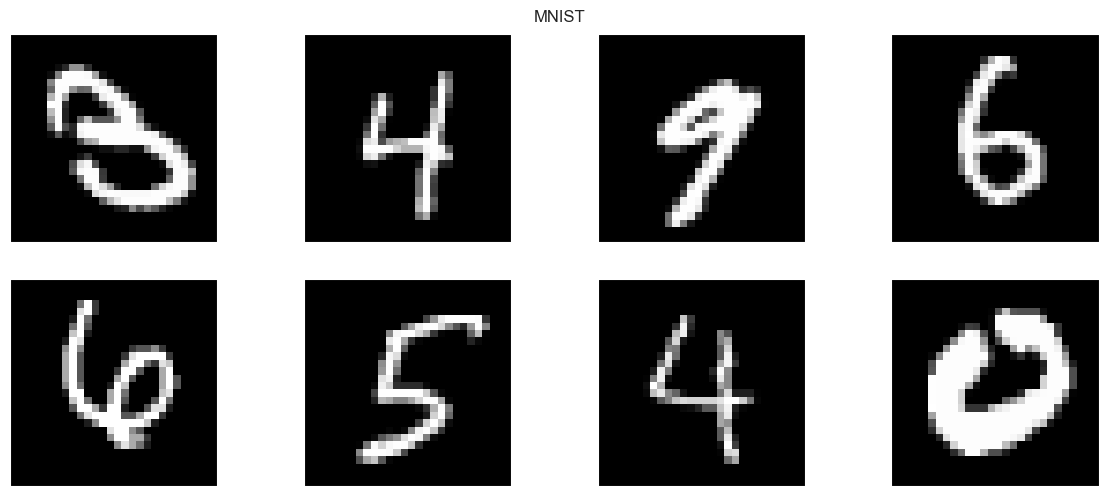

In [10]:
display_images(batch_fixed, 'MNIST', 8)

# Building network

In [11]:
class VAE:
    def __init__(self, input_dim: int = 784, latent_dim: int = 128, seed: int = 21):
        self.rng = np.random.default_rng(seed)

        # Encoder
        self.Encoder = NeuralNetwork()
        self.Encoder.add(Linear(in_neurons=input_dim, out_neurons=512, random_seed=seed))
        self.Encoder.add(ReLU())
        self.Encoder.add(Linear(in_neurons=512, out_neurons=256, random_seed=seed))
        self.Encoder.add(ReLU())

        self.mu_layer = Linear(in_neurons=256, out_neurons=latent_dim, random_seed=seed)
        self.log_var_layer = Linear(in_neurons=256, out_neurons=latent_dim, random_seed=seed)

        # Decoder
        self.Decoder = NeuralNetwork()
        self.Decoder.add(Linear(in_neurons=latent_dim, out_neurons=256, random_seed=seed))
        self.Decoder.add(ReLU())
        self.Decoder.add(Linear(in_neurons=256, out_neurons=512, random_seed=seed))
        self.Decoder.add(ReLU())
        self.Decoder.add(Linear(in_neurons=512, out_neurons=input_dim, random_seed=seed))
        self.Decoder.add(Sigmoid())

    def feedforward(self, x: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
        curr_x = x.reshape(-1, 1)
        # Encode
        for layer in self.Encoder.layers:
            curr_x = layer.feedforward(curr_x)

        self.mu = self.mu_layer.feedforward(curr_x)
        self.log_var = self.log_var_layer.feedforward(curr_x)

        # Reparameterization trick
        std = np.exp(0.5 * self.log_var)
        eps = rng.standard_normal(std.shape)
        self.z = self.mu + eps * std
        curr_x = self.z

        # Decode
        for layer in self.Decoder.layers:
            curr_x = layer.feedforward(curr_x)

        return curr_x.reshape(1, 28, 28), self.mu, self.log_var

    def backprop(self, d_recon: np.ndarray, d_mu_kld: np.ndarray, d_log_var_kld: np.ndarray, lr: float) -> None:
        # Reconstruction backward
        d_curr = d_recon.reshape(-1, 1)

        # decoder backprop
        for layer in reversed(self.Decoder.layers):
            d_curr = layer.backprop(d_curr, lr=lr)

        d_z = d_curr
        # d_mu = d_z
        d_mu = d_z
        # d_log_var = d_z * 0.5 * eps * std (eps * std == z - mu)
        d_log_var = d_z * 0.5 * (self.z - self.mu)

        # Adding gradients of KLD
        d_mu += d_mu_kld
        d_log_var += d_log_var_kld

        d_mu_enc = self.mu_layer.backprop(d_mu, lr=lr)
        d_log_var_enc = self.log_var_layer.backprop(d_log_var, lr=lr)

        # Encoder backprop
        d_curr = d_mu_enc + d_log_var_enc
        for layer in reversed(self.Encoder.layers):
            d_curr = layer.backprop(d_curr, lr=lr)

In [12]:
vae = VAE(seed=seed)

## Train

In [13]:
bce_loss = BinaryCrossEntropy()
kld_loss = KLDivergence()

In [14]:
lr = 1e-3

Entry level of reconstruction

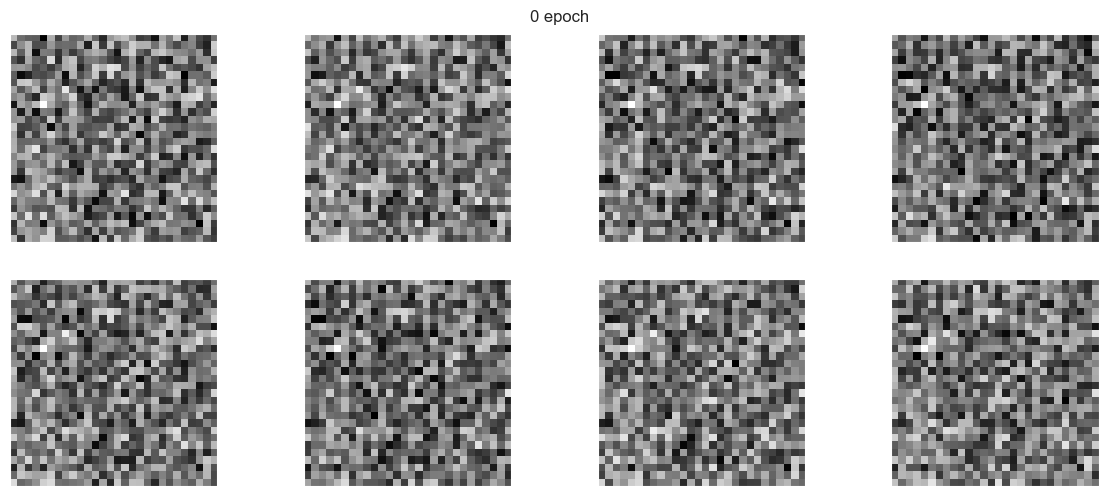

In [15]:
images_to_display = np.zeros((8, 1, 28, 28))
for j in range(batch_fixed.shape[0]):
    images_to_display[j, :, :, :], _, _ = vae.feedforward(batch_fixed[j])
display_images(images=images_to_display, title=f'0 epoch', display_count=8)

In [17]:
def train(model, epochs: int = 10, lr: float = 1e-3) -> np.ndarray:
    loss_history = []

    for epoch in range(epochs):
        epoch_loss_value = 0

        rng.shuffle(x_train)
        for i in tqdm(range(x_train.shape[0])):
            x_recon, mu, log_var = vae.feedforward(x_train[i])
            loss_value = np.mean(bce_loss.fn(x_train[i], x_recon)) + np.mean(kld_loss.fn(mu, log_var))
            loss_history.append(loss_value)
            epoch_loss_value += loss_value

            if i % 64 == 0:
                d_bce = bce_loss.dfn(x_train[i], x_recon)
                d_mu, d_log_var = kld_loss.dfn(mu, log_var)
                vae.backprop(d_recon=d_bce, d_mu_kld=d_mu, d_log_var_kld=d_log_var, lr=lr)

        epoch_loss_value /= x_train.shape[0]
        print(f'''
                Epoch {epoch + 1}/{epochs}"
                Loss: {epoch_loss_value}
        ''')

        images_to_display = np.zeros((8, 1, 28, 28))
        for j in range(batch_fixed.shape[0]):
            images_to_display[j, :, :, :], _, _ = vae.feedforward(batch_fixed[j])
        display_images(images=images_to_display, title=f'Epoch {epoch + 1}', display_count=8)

    return loss_history

100%|██████████| 60000/60000 [01:15<00:00, 791.75it/s] 



                Epoch 1/4"
                Loss: 4.3107866731856115
        


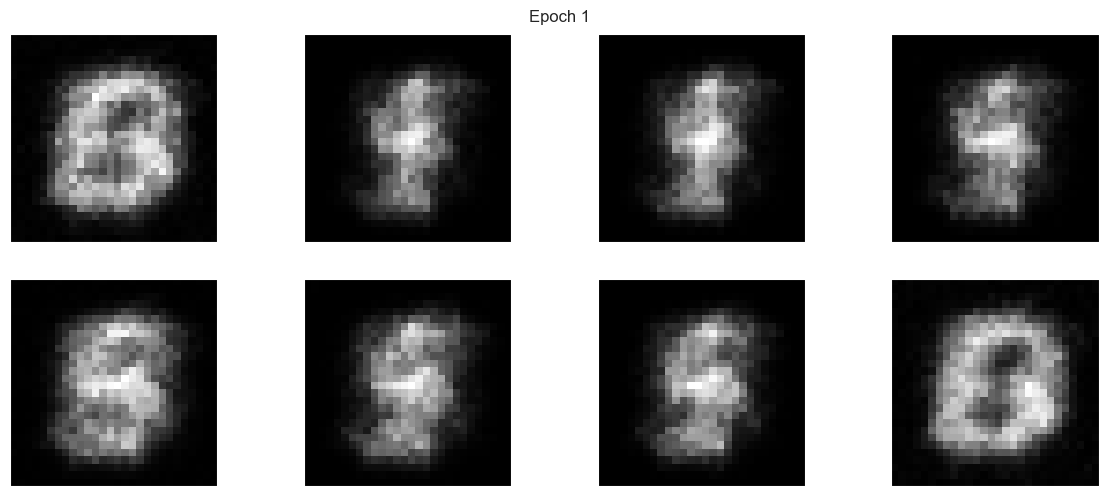

100%|██████████| 60000/60000 [01:00<00:00, 994.71it/s] 



                Epoch 2/4"
                Loss: 6.38530655208976
        


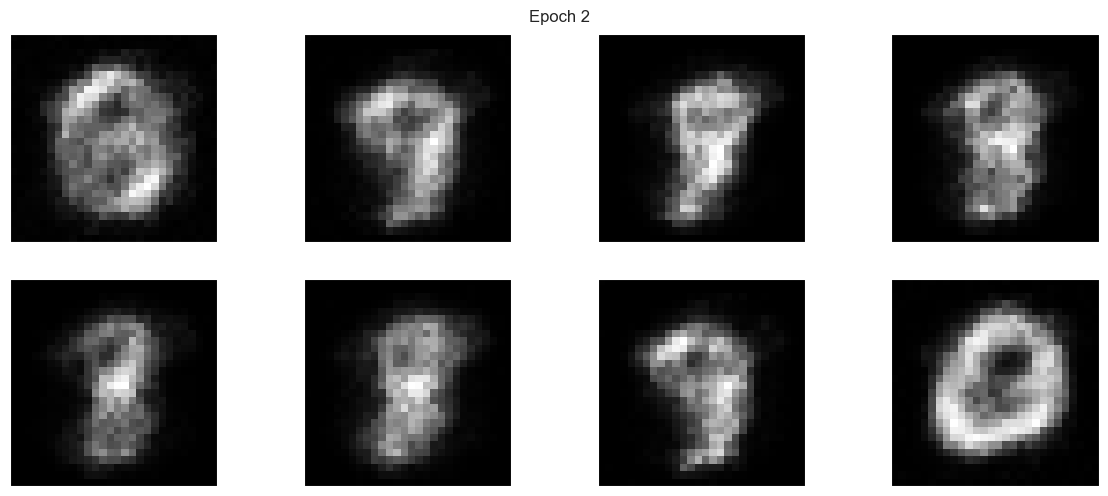

100%|██████████| 60000/60000 [00:58<00:00, 1022.78it/s]



                Epoch 3/4"
                Loss: 9.788627560269024
        


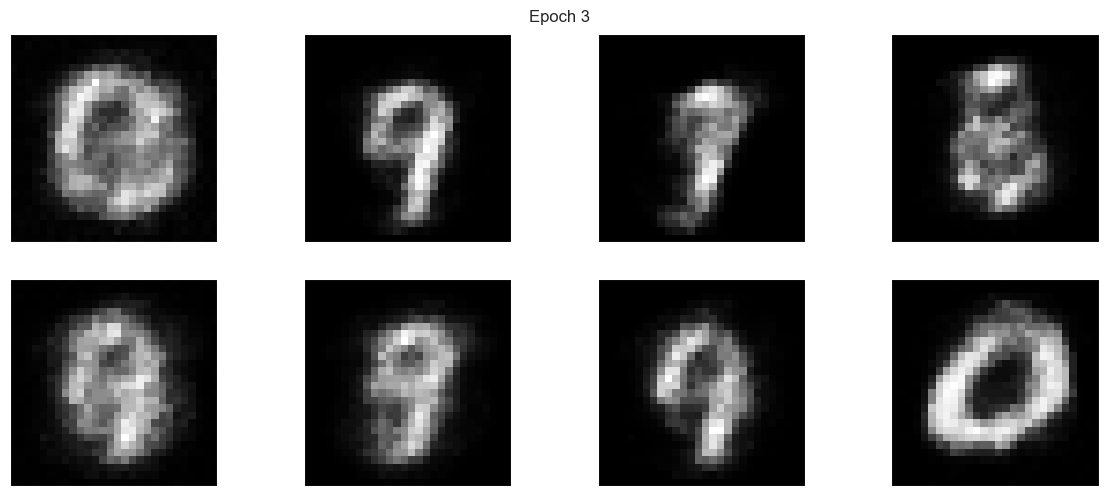

100%|██████████| 60000/60000 [00:58<00:00, 1030.93it/s]



                Epoch 4/4"
                Loss: 12.28876347533802
        


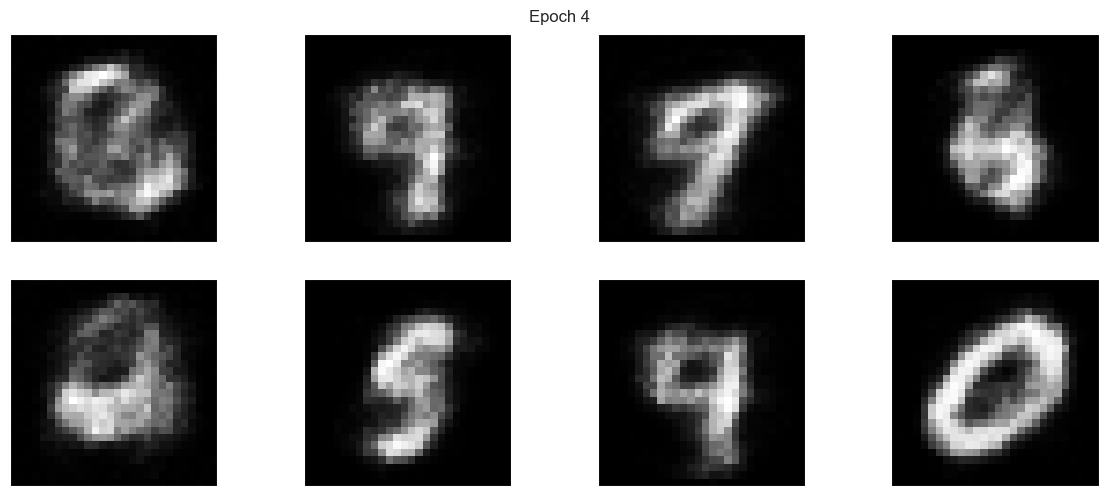

In [18]:
loss_history = train(model=vae, epochs=4, lr=lr)

First epoch loss - 82.20408520468264
Last epoch loss - 7.737022689656609


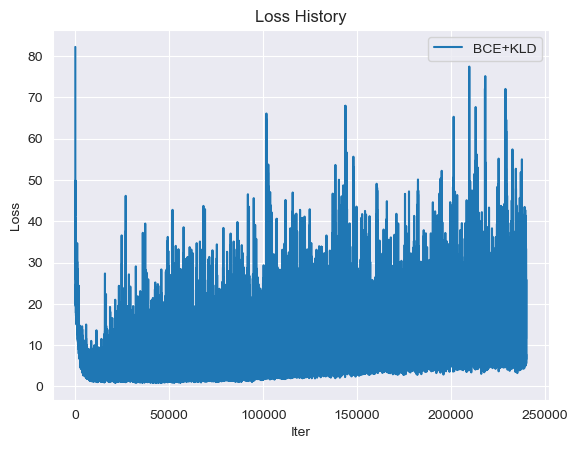

In [19]:
plt.plot(loss_history, label="BCE+KLD")
plt.legend()
plt.title("Loss History")
plt.xlabel('Iter')
plt.ylabel('Loss')
print(f"First epoch loss - {loss_history[0]}\nLast epoch loss - {loss_history[-1]}")